In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['rapl'])
from common import *
from plotcommon import *
from cla_util import *
from rayleigh_diagnostics import GridInfo

In [2]:
dirname = '/nobackup/lmatilsk/ff4-3_test_equations/'

In [3]:
os.listdir(dirname + 'data')

['G_Avgs_trace_nquadlat2_nquadr2-01600001_01600100.pkl',
 'Shell_Avgs_trace-01600001_01600100.pkl',
 'G_Avgs_trace-01600001_01600100.pkl',
 'Point_Probes_trace-01600001_01600100.pkl']

In [4]:
# get point probes data
di = get_dict(dirname + 'data/Point_Probes_trace-01600001_01600100.pkl')
vals = di['vals']
times = di['times']
iters = di['iters']
lut = di['lut']
rvals = di['rvals']
thetavals = di['thetavals']
phivals = di['phivals']

# get grid info
di_grid = get_grid_info(dirname)
rr = di_grid['rr']
tt = di_grid['tt']
phi = di_grid['phi']
tt_lat = di_grid['tt_lat']
lons = di_grid['lons']

irvals = inds_from_vals(rr, rvals)
ithetavals = inds_from_vals(tt, thetavals)
iphivals = inds_from_vals(phi, phivals)

print ('irvals = ', irvals)
print ('ithetavals = ', ithetavals)
print ('iphivals = ', iphivals)

print ('rvals/rsun = ', rr[irvals]/rsun)
print ('tt_lat = ', tt_lat[ithetavals])
print ('lons = ', lons[iphivals])

print ('shape(vals) = ', np.shape(vals))
print ('nphi, ntheta, nr = ', di_grid['nphi'], di_grid['nt'], di_grid['nr'])

irvals =  [ 12  20  29  36  42  48  53  58  61  63  66  69  74  79  85  91  98 107
 115]
ithetavals =  [ 10  24  48  72  95 119 143 167 181]
iphivals =  [  0  48  96 144 191 239 287 335]
rvals/rsun =  [0.94136108 0.93255649 0.91808656 0.90391949 0.89008937 0.87501668
 0.86174167 0.84802967 0.83967832 0.83408691 0.82569769 0.81734634
 0.80363434 0.79035933 0.77528664 0.76145652 0.74728945 0.73281952
 0.72401493]
tt_lat =  [-79.94696225 -66.85669072 -44.41539505 -21.97394799  -0.46753089
  21.97394799  44.41539505  66.85669072  79.94696225]
lons =  [  0.      45.      90.     135.     179.0625 224.0625 269.0625 314.0625]
shape(vals) =  (100, 8, 9, 19, 44)
nphi, ntheta, nr =  384 192 128


In [5]:
prot = compute_Prot(dirname)
t = times/prot

In [6]:
np.diff(times)

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])

In [7]:
# thermo state
eq = get_eq(dirname)

In [8]:
iir0, iit0, iiphi0 = 4,6,3

ir0, it0, iphi0 = irvals[iir0], ithetavals[iit0], iphivals[iiphi0]

print ("r/rsun = ", rvals[iir0]/rsun)
print ("lat = ", tt_lat[it0])
print ("lon = ", lons[iphi0])

rhovr = vals[:, iiphi0, iit0, iir0, lut[201]]

adv_r = -vals[:, iiphi0, iit0, iir0, lut[1201]]
buoy = vals[:, iiphi0, iit0, iir0, lut[1216]]
cor_r = vals[:, iiphi0, iit0, iir0, lut[1219]]

visc_r = vals[:, iiphi0, iit0, iir0, lut[1228]]
gradp_r = vals[:, iiphi0, iit0, iir0, lut[1237]]

#jxb_r = vals[:, iiphi0, iit0, iir0, lut[1248]]

r/rsun =  0.8900893660965623
lat =  44.41539505235375
lon =  135.0


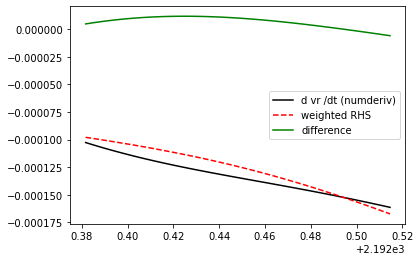

In [9]:
# compare two forces

# discrete time derivative (LHS)
drhovr = rhovr[2:] - rhovr[1:-1]
dt = times[2:] - times[1:-1]
dt_old = times[1:-1] - times[:-2]
drhovrdt = drhovr/dt

# RHS (some of source/sink terms)
f_exp = cor_r + adv_r# + jxb_r
f_imp = gradp_r + buoy + visc_r
rhs_momr = f_weighted = 0.5*(f_imp[2:] + f_imp[1:-1]) + f_exp[1:-1] + 0.5*(dt/dt_old)*(f_exp[1:-1] - f_exp[:-2])

plt.plot(t[2:], drhovrdt, 'k', label='d vr /dt (numderiv)')
plt.plot(t[2:], f_weighted, 'r--', label='weighted RHS')
plt.plot(t[2:], f_weighted - drhovrdt, 'g', label='difference')

#plt.plot(t, f_r/rho[ir0], label='weighted RHS')

plt.legend()

In [10]:
# well that looks pretty good!

In [11]:
#Let's look at rho_v_theta
rhovt = vals[:, iiphi0, iit0, iir0, lut[202]]

adv_t = -vals[:, iiphi0, iit0, iir0, lut[1202]]
cor_t = vals[:, iiphi0, iit0, iir0, lut[1220]]

visc_t = vals[:, iiphi0, iit0, iir0, lut[1229]]
gradp_t = vals[:, iiphi0, iit0, iir0, lut[1238]]

#jxb_t = vals[:, iiphi0, iit0, iir0, lut[1249]]

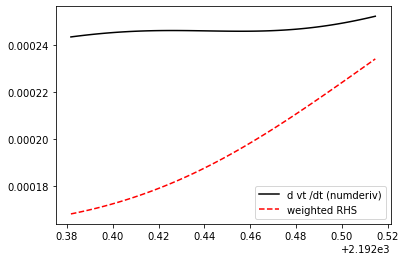

In [12]:
drhovt = rhovt[2:] - rhovt[1:-1]
drhovtdt = drhovt/dt

f_exp = cor_t + adv_t# + jxb_t
f_imp = gradp_t + visc_t

rhs_momt = f_weighted = 0.5*(f_imp[2:] + f_imp[1:-1]) + f_exp[1:-1] + 0.5*(dt/dt_old)*(f_exp[1:-1] - f_exp[:-2])

plt.plot(t[2:], drhovtdt, 'k', label='d vt /dt (numderiv)')
plt.plot(t[2:], f_weighted, 'r--', label='weighted RHS')
#plt.plot(t, f_r/rho[ir0], label='weighted RHS')

plt.legend()

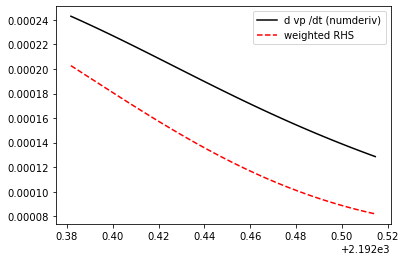

In [13]:
# and then phi
rhovp = vals[:, iiphi0, iit0, iir0, lut[203]]
drhovp = rhovp[2:] - rhovp[1:-1]
drhovpdt = drhovp/dt

adv_p = -vals[:, iiphi0, iit0, iir0, lut[1203]]
cor_p = vals[:, iiphi0, iit0, iir0, lut[1221]]

visc_p = vals[:, iiphi0, iit0, iir0, lut[1230]]
gradp_p = vals[:, iiphi0, iit0, iir0, lut[1239]]

#jxb_p = vals[:, iiphi0, iit0, iir0, lut[1250]]

f_exp = cor_p + adv_p# + jxb_p
f_imp = gradp_p + visc_p
rhs_momp = f_weighted = 0.5*(f_imp[2:] + f_imp[1:-1]) + f_exp[1:-1] + 0.5*(dt/dt_old)*(f_exp[1:-1] - f_exp[:-2])

plt.plot(t[2:], drhovpdt, 'k', label='d vp /dt (numderiv)')
plt.plot(t[2:], f_weighted, 'r--', label='weighted RHS')
#plt.plot(t, f_r/rho[ir0], label='weighted RHS')

plt.legend()

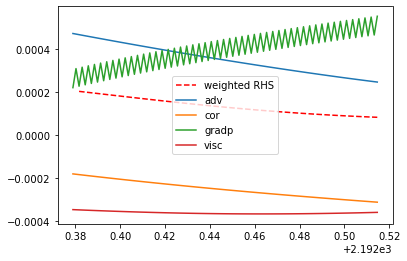

In [14]:
# break up phi momentum into more pieces
plt.plot(t[2:], f_weighted, 'r--', label='weighted RHS')
plt.plot(t, adv_p, label='adv')
plt.plot(t, cor_p, label='cor')
plt.plot(t, gradp_p, label='gradp')
plt.plot(t, visc_p, label='visc')

         
#plt.plot(t, f_r/rho[ir0], label='weighted RHS')

plt.legend()

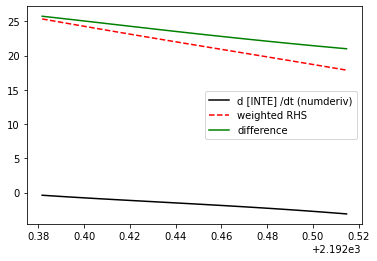

In [15]:
# for good measure, see what heat equation does
inte = vals[:, iiphi0, iit0, iir0, lut[701]]
dinte = inte[2:] - inte[1:-1]
dintedt = dinte/dt

adv_heat = -vals[:, iiphi0, iit0, iir0, lut[1401]]
ref_adv_heat = -rhovr*(eq.T*eq.dsdr)[ir0]
cond_heating = vals[:, iiphi0, iit0, iir0, lut[1421]]
int_heating = vals[:, iiphi0, iit0, iir0, lut[1434]]
visc_heating = vals[:, iiphi0, iit0, iir0, lut[1435]]

f_exp = adv_heat + visc_heating# + joule_heating
f_imp = ref_adv_heat + cond_heating + int_heating
f_weighted = 0.5*(f_imp[2:] + f_imp[1:-1]) + f_exp[1:-1] + 0.5*(dt/dt_old)*(f_exp[1:-1] - f_exp[:-2])

plt.plot(t[2:], dintedt, 'k', label='d [INTE] /dt (numderiv)')
plt.plot(t[2:], f_weighted, 'r--', label='weighted RHS')
#plt.plot(t, f_r/rho[ir0], label='weighted RHS')
plt.plot(t[2:], f_weighted - dintedt, 'g', label='difference')

plt.legend()

In [16]:
# yeah this guy isn't so hot

In [18]:
# check numerical errors in the momentum equation
print ("err mom r = ", rms(rhs_momr - drhovrdt)/rms(drhovrdt))
print ("err mom t = ", rms(rhs_momt - drhovtdt)/rms(drhovtdt))
print ("err mom p = ", rms(rhs_momp - drhovpdt)/rms(drhovpdt))

err mom r =  0.06074841787053121
err mom t =  0.22135123892021005
err mom p =  0.27216166846578693
